# Using the Hazard Modeller's Toolkit - Earthquake Catalogue Examples 

This notebook contains: 

1. Read a seismic catalogue and pre-defined seismic sources. 

2. Explore basic methods for qualitative analysis of the catalogue. 

3. Declustering: Aftershocks and foreshocks identification and removal. 

4. Completeness

5. Estimation of the Gutenberg-Richter parameters. 

6. Exploration of some methods to estimate the maximum magnitude (statistically from the catalogue)


### Importing the libraries and Dependencies

To use the toolkit features we need to import at the start of the session those tools that we are planning to use.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline  

# Python dependences
import os
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from hmtk.seismicity.selector import CatalogueSelector
from hmtk.seismicity.declusterer.dec_afteran import Afteran 
from hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                               GruenthalWindow, 
                                                               UhrhammerWindow)

# Completeness tools
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Recurrence methods
from hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment 

# Seismicity tools: Smoothed seismicity
from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity 
from hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian 

print("Everything Imported OK!")

Everything Imported OK!


### Importing the Catalogue (+ Useful Methods!)

Seismic catalogue format

The hmtk is able to read a catalogue in .csv format (Windows comma separated values). 
There are a minimum number of fields that are required to import and use the catalogue 
information into hmtk. 
The fields require: 

        eventID* Agency year* month* day* hour* minute* second* longitude* latitude* depth* magnitude*

The fields marked with a star are mandatory.



In [3]:
#Importing catalogue
catalogue_filename = 'input_data/Overall_Seismicity_Formatted_2021.11.16.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file(start_year=1619, end_year=2021)

# How many events in the catalogue?
print("The catalogue contains %g events" % catalogue.get_number_events())

# What is the geographical extent of the catalogue?
bbox = catalogue.get_bounding_box()
print("Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox)

The catalogue contains 14929 events
Catalogue ranges from 116.1348 E to 128.5000 E Longitude and 4.0000 N to 21.1000 N Latitude



It is generally a good idea for the catalogue to be input in chronological order.

If the catalogue is not in chronological order then the following re-sorts the catalogue in-place to ensure it is in order



In [4]:
catalogue.sort_catalogue_chronologically()

print("Catalogue Sorting OK!")

Catalogue Sorting OK!


### Visualising the catalogue

#### Magnitude - Time Density

To see how the distribution of magnitudes changes with time we can simply plot magnitude against time:

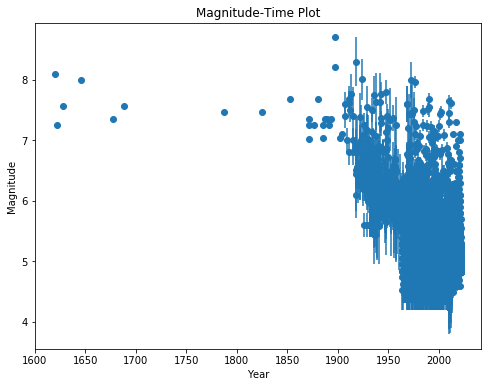

In [5]:
plot_magnitude_time_scatter(catalogue, plot_error=True)

Or, more informatively, plot the density of events with time

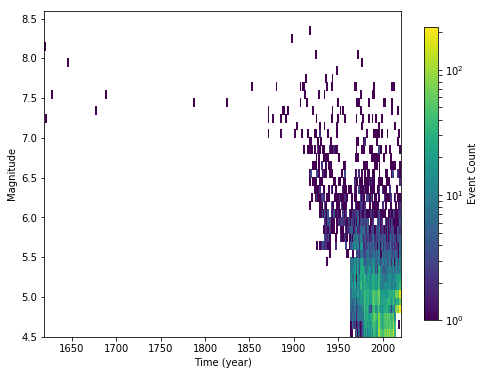

In [6]:
magnitude_bin_width = 0.1  # In magnitude units
time_bin_width = 1.0 # In years
plot_magnitude_time_density(catalogue, magnitude_bin_width, time_bin_width)

### View the Depth Distribution

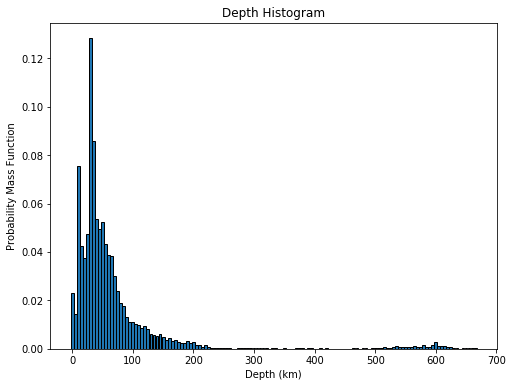

In [7]:
# Shows depth histogram every 5 km  
plot_depth_histogram(catalogue, 5, normalisation=True)

### Mapping the Catalogue

We can map the catalogue using the HMTK's mapping functions. A 'basemap' can support multiple layers:

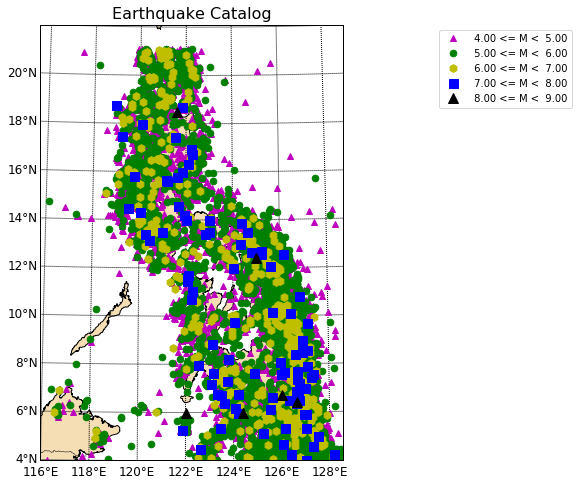

In [8]:
# Map configuration
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}

# Creating a basemap - input a cconfiguration and (if desired) a title
basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalog')


# Adding the catalogue to the basemap
# In this case we will 'close' the figure after rendering, we do this by setting 'overlay=False'
# This is also the default option
# If we wanted to add another layer on top, we would set the overlay to True
basemap1.add_catalogue(catalogue, overlay=False)

### Declustering

The HMTK supports several methods for declustering the earthquake catalogue:

1. Gardner & Knopoff (1974)

2. AFTERAN (Musson, 1999)

Others will (eventually) be added in the future

We illustrate the use of the Gardner & Knopoff Algorithm

#### Configuring the algorithm

In [9]:
# Create an `instance' of the tool
declust_method = GardnerKnopoffType1()

# Create a configuration file
declust_config = {"time_distance_window": GardnerKnopoffWindow(), "fs_time_prop": 1.0}

### Running the algorithm

All declustering algorithms produce two outputs:

* cluster_index = Vector indicating the number of the cluster to which the earthquake belongs (including mainshock)
* cluster_flag = Vector indicating if the event is a foreshock (-1), mainshock (0) or aftershock (1)

In [10]:
cluster_index, cluster_flag = declust_method.decluster(catalogue, declust_config)

data = np.column_stack([catalogue.get_decimal_time(),
                        catalogue.data['magnitude'],
                        catalogue.data['longitude'],
                        catalogue.data['latitude'], cluster_index, cluster_flag])
print('      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)')
for row in data:
    print('%14.8f  %6.2f  %8.3f  %8.3f  %6.0f  %6.0f' %(row[0], row[1], row[2], row[3], row[4], row[5]))

      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)
 1619.91278539    8.10   121.600    18.500       0       0
 1621.91643836    7.25   122.100    11.700       0       0
 1627.66712329    7.57   121.800    18.700       0       0
 1645.91369863    7.99   121.200    15.600       0       0
 1677.93287671    7.36   119.500    14.500       0       0
 1688.79918033    7.57   122.200    16.950       0       0
 1787.52862443    7.46   122.250    11.050       0       0
 1824.81830601    7.46   121.900    14.200       0       0
 1852.70884563    7.68   120.050    14.300       0       0
 1871.84520548    7.36   126.900     8.900      25       0
 1871.93561644    7.02   123.750     7.300       0       0
 1871.96575342    7.25   126.900     8.500      25       1
 1876.56420765    7.25   126.400    10.100       0       0
 1880.54424712    7.68   121.850    16.000       0       0
 1885.14383562    7.25   127.100     7.900       0       0
 1885

 1976.63747387    5.55   123.823     6.730       3       1
 1976.63772445    5.28   123.765     6.850       3       1
 1976.63849416    5.17   123.856     7.097    1062       1
 1976.63891482    5.28   123.676     6.821       3       1
 1976.63895276    5.06   123.745     6.636       3       1
 1976.63900952    5.17   124.102     6.370       3       1
 1976.64038116    4.95   124.136     6.749       3       1
 1976.64249919    5.96   124.124     6.520       3       1
 1976.64896399    5.87   124.430    13.056     270      -1
 1976.64956127    5.39   123.790     6.816       3       1
 1976.65752301    5.17   123.613     7.055      38       1
 1976.65807617    5.06   124.070     6.505       3       1
 1976.65824526    5.17   123.483     7.215      38       1
 1976.65878229    5.49   124.092     6.926       3       1
 1976.65909718    5.39   121.938    12.419       0       0
 1976.66143030    5.76   123.955     6.597       3       1
 1976.66267474    5.06   125.928     8.499      69      

 1984.47254667    5.06   125.533    10.078     499      -1
 1984.47409676    5.49   123.901     8.227      28       1
 1984.47845597    4.95   125.791    12.182     602       1
 1984.48083298    5.06   125.748    12.045     602       1
 1984.48193275    4.63   125.671    11.885     602       1
 1984.48733494    5.28   120.237    20.880     936       0
 1984.48872844    4.96   123.948     6.813     943      -1
 1984.52371751    4.52   121.799    20.958       0       0
 1984.52523585    5.83   126.488     5.567     109       1
 1984.53923781    5.06   126.972     5.798    1253       0
 1984.55029530    4.84   127.930     4.032       0       0
 1984.55111294    5.06   124.920    12.235    1254       0
 1984.55419997    5.28   126.629     4.858     548       1
 1984.57046509    5.17   120.744    15.845      67      -1
 1984.58555910    5.27   123.719     6.762     943       0
 1984.58563406    5.28   124.244     7.114     937       0
 1984.61375733    4.95   119.276    13.735       0      

 1990.73877275    5.04   126.838     7.334      32      -1
 1990.74773350    5.02   120.535    16.028       7       1
 1990.74941016    4.67   124.249    14.557       0       0
 1990.74951484    4.96   123.890    14.481       0       0
 1990.75408810    4.74   125.271    11.998    1282       1
 1990.75411520    4.90   125.424    11.561    1287      -1
 1990.76248133    4.79   126.407     5.213     424       1
 1990.76279028    5.26   120.363    13.494     844      -1
 1990.76541555    4.79   127.157     7.766       0       0
 1990.76631971    5.02   125.963    10.142     212      -1
 1990.77283096    4.56   125.949     5.363       0       0
 1990.78100120    4.67   122.226    17.990     735       1
 1990.78133284    5.11   122.583     9.021    1169       0
 1990.78383037    5.08   120.481    16.416     208       1
 1990.79463784    4.71   121.279    19.930       0       0
 1990.79940822    4.90   125.932    10.881    1438       0
 1990.79981774    4.77   123.711     6.511       0      

 1996.44475267    4.56   125.132    12.632      46       1
 1996.44475928    5.02   125.277    12.723      46       1
 1996.44481312    4.90   125.151    12.683      46       1
 1996.44492451    4.63   125.145    12.550      36       1
 1996.44510476    5.02   125.197    12.727      46       1
 1996.44541271    5.49   125.215    12.716      46       1
 1996.44541869    5.26   125.088    12.620      46       1
 1996.44811659    4.52   125.312    12.849      46       1
 1996.45141819    5.02   124.889    12.844      46       1
 1996.45209267    4.56   124.819    12.804      46       1
 1996.45252774    4.67   125.186    12.562      36       1
 1996.45253623    6.08   124.941    12.853      46       1
 1996.45256578    4.56   124.905    12.899      46       1
 1996.45401862    4.52   125.006    12.052      36       1
 1996.45413274    5.19   121.520    10.251     315      -1
 1996.45510992    4.79   125.047    12.824      46       1
 1996.45515721    4.53   121.596    10.116     315      

 2003.31167545    4.71   126.525    10.171    1601       0
 2003.31679932    5.05   125.515     6.013     157       1
 2003.31938147    4.52   126.828     9.298    1051       1
 2003.31965125    5.48   125.899     5.387     678       0
 2003.32209868    4.56   127.258     7.025      21       1
 2003.32650229    4.56   120.358    15.328    1421      -1
 2003.32790981    4.90   126.726     7.026      21       1
 2003.32912655    4.56   126.483     9.730    1133      -1
 2003.33015395    4.56   120.036    13.847     117      -1
 2003.33327703    5.36   123.983    11.990     163       1
 2003.33572927    4.56   125.929     4.912    1055      -1
 2003.34193972    4.53   124.798    12.732     278      -1
 2003.34349907    4.65   120.534    20.671       0       0
 2003.35128374    4.56   126.616     5.457     831       1
 2003.35271998    4.65   119.231    18.263       0       0
 2003.35374291    4.56   125.191    12.216     103      -1
 2003.35461914    5.25   122.529    17.284       0      

 2009.75741629    6.63   123.504     6.674       8      -1
 2009.75742791    5.64   123.513     6.632       8      -1
 2009.75743488    5.02   123.553     6.761       8      -1
 2009.75844025    4.63   126.004     6.013    1441      -1
 2009.76685928    6.77   122.530     4.105      73       0
 2009.76686267    5.60   122.529     4.031      73       1
 2009.77986469    4.77   119.450    18.442    1590       0
 2009.79003428    4.67   126.939     5.798    1022      -1
 2009.79054576    5.02   127.439     5.021     161       1
 2009.79675408    4.53   125.699     9.194     412      -1
 2009.79724157    5.67   120.684    13.772     299       1
 2009.80208397    4.83   125.671    12.262     621      -1
 2009.81612796    4.79   126.564     7.588     301      -1
 2009.81918937    4.83   124.716     6.446     473       1
 2009.81989781    4.67   126.137     6.135     426       1
 2009.82131026    4.56   124.912    13.524       0       0
 2009.82522823    4.79   125.935     5.925     147      

 2017.54878863    4.82   126.785    10.297     836       1
 2017.54880926    5.29   126.777     4.486     458      -1
 2017.54985482    4.94   119.769    17.164       0       0
 2017.56391128    5.08   122.098    10.219    1202       0
 2017.56397395    4.88   122.060    10.161    1202       1
 2017.57334764    4.82   119.778    14.866       0       0
 2017.57407662    4.94   120.797    12.902       0       0
 2017.58493010    4.94   125.524     4.733    1261       1
 2017.59183921    5.80   125.415     6.115     375       0
 2017.59265471    5.25   125.221     7.921       0       0
 2017.59306109    4.82   125.341    10.125     107       1
 2017.60310073    5.15   126.040     9.342     716       1
 2017.60556187    5.37   124.087     9.498     247       1
 2017.60672703    4.88   125.474    11.518     124      -1
 2017.60884404    6.20   120.739    14.007     182       0
 2017.61088785    5.03   120.711    13.903     182       1
 2017.61299727    5.22   120.670    13.962     182      

### Purging non-Poissonian Events from the Catalogue

Having run the declustering algorithm you may want to remove all of the 'non-Poissonian' events (i.e. foreshocks and aftershocks) from the catalogue

In [11]:
# Copying the catalogue and saving it under a new name "catalogue_dec"(declustered catalogue) 
catalogue_dec = deepcopy(catalogue)

# Logical indexing: Chossing the outputs for the main events: Cluster_flag = 0 
mainshock_flag = cluster_flag == 0 

# Filtering the foreshocks and aftershocks in the copy of the catalogue 
catalogue_dec.purge_catalogue(mainshock_flag)


# Printing the number of events considered main shocks
print('Declustering: ok')
print("Number of events in original catalogue: %g" % catalogue.get_number_events())
print('Number of mainshocks: %g' % catalogue_dec.get_number_events())

Declustering: ok
Number of events in original catalogue: 14929
Number of mainshocks: 4188


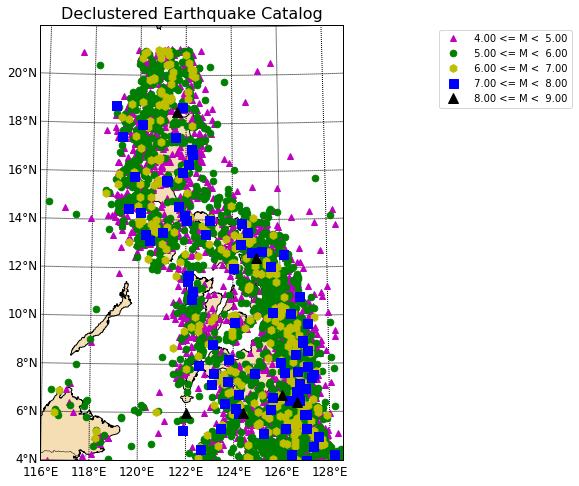

In [12]:
basemap1 = HMTKBaseMap(map_config, 'Declustered Earthquake Catalog')
basemap1.add_catalogue(catalogue_dec, overlay=False)

### Saving the catalogue

In [13]:
# Selecting path and name for the output file 
output_cat_dec = 'output_data/Overall_Seismicity_Dec_2021.11.16.csv'

if os.path.exists(output_cat_dec):
    os.remove(output_cat_dec)

# Call the method and save the output file under the name "cat_csv"
cat_csv = CsvCatalogueWriter(output_cat_dec) 

# Write the purged catalogue
cat_csv.write_file(catalogue_dec)
print("Catalogue successfully written to %s" % output_cat_dec)

Catalogue successfully written to output_data/Overall_Seismicity_Dec_2021.11.16.csv


### Analysis of Completeness

Completeness: ok


Completeness table using Stepp method (1971)
[[1980.     4.5]
 [1972.     5. ]
 [1949.     5.5]
 [1928.     6. ]
 [1903.     6.5]
 [1899.     7. ]
 [1863.     7.5]
 [1830.     8. ]]




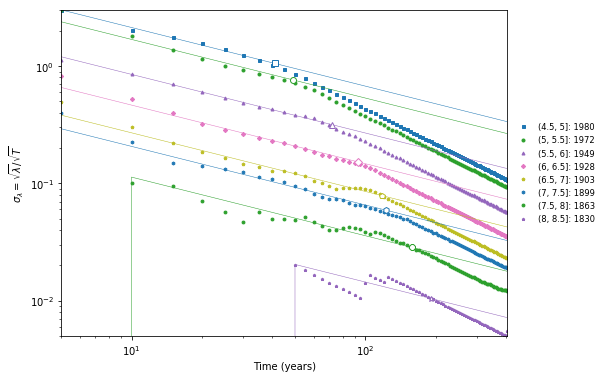

In [14]:
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.5, 'time_bin': 5.0, 'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue_dec, comp_config)
print('Completeness: ok')

# Print the completeness table
print('\n')
print('Completeness table using Stepp method (1971)')
print(completeness_table)
print('\n')

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = "output_data/Project_Completeness_Plot.png"
if os.path.exists(output_file):
    os.remove(output_file)
# plot_stepp_1972.create_stepp_plot(completeness_parameters, filename=output_file)
plot_stepp_1972.create_stepp_plot(completeness_parameters, filename=output_file, filetype='png', dpi=500, ax=None)

### Manual setup of the completeness table

The hmtk allows to use a completeness table proposed by the modeller. 

In [15]:
# truncate catalogue to years 1900 and above for plotting

cat_dec_plot = deepcopy(catalogue_dec)
cat_years = cat_dec_plot.data['year']
cat_mon = cat_dec_plot.data['month']
cat_day = cat_dec_plot.data['day']
cat_hr = cat_dec_plot.data['hour']
cat_min = cat_dec_plot.data['minute']
cat_sec = cat_dec_plot.data['second']
cat_mags = cat_dec_plot.data['magnitude']

#cat_recent_years = cat_years >= 1619
cat_recent_years = cat_years >= 1900
cat_dec_plot.data['year'] = cat_years[cat_recent_years]
cat_dec_plot.data['month'] = cat_mon[cat_recent_years]
cat_dec_plot.data['day'] = cat_day[cat_recent_years]
cat_dec_plot.data['hour'] = cat_hr[cat_recent_years]
cat_dec_plot.data['minute'] = cat_min[cat_recent_years]
cat_dec_plot.data['second'] = cat_sec[cat_recent_years]
cat_dec_plot.data['magnitude'] = cat_mags[cat_recent_years]

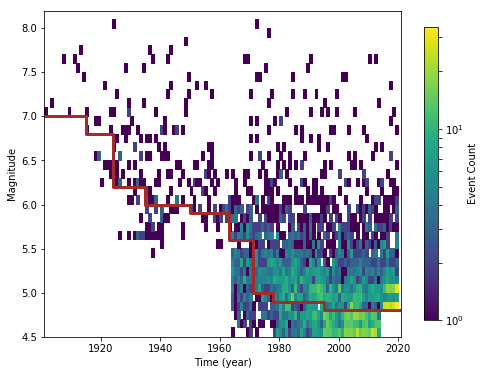

In [16]:
# Table format
completeness_table_a = np.array([[1995, 4.8],
                                 [1978, 4.9],
                                 [1971, 5.0],
                                 [1963, 5.6],
                                 [1950, 5.9],
                                 [1935, 6.0],
                                 [1924, 6.2],
                                 [1915, 6.8],
                                 [1871, 7.0],
                                 [1863, 7.5],
                                 [1619, 8.2]])
    
plot_magnitude_time_density(cat_dec_plot, 0.1, 1.0,
                            completeness=completeness_table_a)

### Estimating Recurrence

Several methods are available for estimating recurrence taking into account time-dependent completeness

1. 'Weighted' Maximum Likelihood
2. Kijko & Smit (2012)
3. Weichert (1980)
4. Penalized Maximum Likelihood (Johnston et al., 1994)

In [17]:
from hmtk.seismicity.occurrence.weichert import Weichert

recurrence_estimator = Weichert()

# recurrence_config = {"magnitude_interval": 0.1}
recurrence_config = {"magnitude_interval": 0.1, "reference_magnitude": None}

bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(catalogue_dec,
                                                              recurrence_config,
                                                              completeness_table_a)

print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))

a = 6.451 (+/- 0.008),  b = 0.980 (+/-0.015)


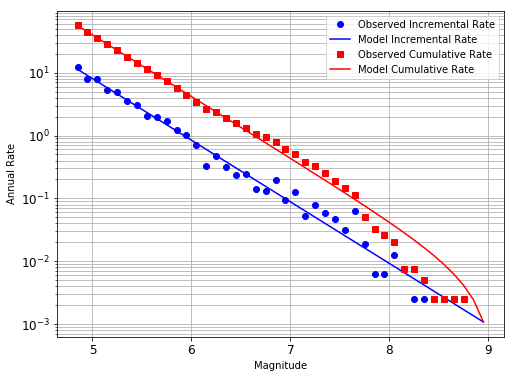

In [18]:
from hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hazardlib.mfd import TruncatedGRMFD
mfd0 = TruncatedGRMFD(4.8, 9.0, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

### Inferring Maximum Magnitude

The toolkit contains several tools for making statistical inferences on the maximum magnitude using the earthquake catalogue.

Three of these are based on the methods proposed by Kijko (2004):

1. KijkoSellevolFixedb - Maximum likelihood estimator of $M_{MAX}$ assuming no uncertainty in the b-value

2. KijkoSellevolBayes - Maximum likelihood estimator of $M_{MAX}$ assuming an uncertain b-value

3. KijkoNonParametricGaussian -Maximum likelihood estimator of $M_{MAX}$ assuming no specific magnitude frequency distribution

More details are given in the HMTK manual.

An additional method - based on cumulative moment release (adaptation of Makropolous & Burton (1983)) is also included



Maximum Magnitude (Kijko Non-Parametric Gaussian): 14.406 +/- nan


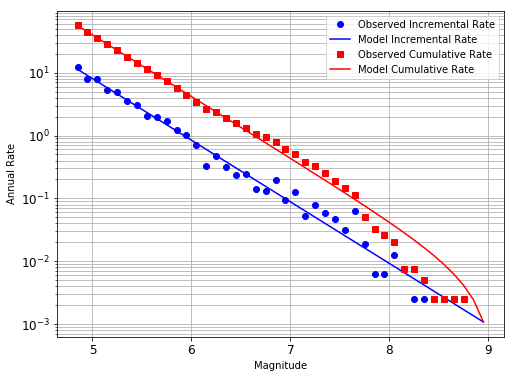

In [19]:
from hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian

mmax_config4 = {'input_mmax4': None,
               'input_mmax_uncertainty4': None,
               'number_samples': 51, # Default
               'number_earthquakes': 100, # Default
               'tolerance': 1.0E-5,
               'maximum_iterations': 1000}

mmax_estimator4 = KijkoNonParametricGaussian()
mmax4, sigma_mmax4 = mmax_estimator4.get_mmax(catalogue_dec, mmax_config4)
print("Maximum Magnitude (Kijko Non-Parametric Gaussian): %.3f +/- %.3f" % (mmax4, sigma_mmax4))

# mmax4, mmax_uncertainty4 = mmax_estimator4.get_mmax(catalogue_dec, mmax_cm_config)
# print("Maximum Magnitude (Kijko Non-Parametric Gaussian): %.3f +/- %.3f" % (mmax4, mmax_uncertainty4))

mfd0 = TruncatedGRMFD(4.8, 9.0, 0.1, aval, bval) # comment this line if not working
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

In [20]:
# Categorize by Depth
import pandas as pd
df = pd.read_csv(output_cat_dec)
pos = output_cat_dec.find("Dec_") + len("Dec_")

df[df['depth']<=50].sort_values(by=['depth']).to_csv(output_cat_dec[:pos] + 
"Shallow_" + output_cat_dec[pos:], index=False)

df[(df['depth']>50) & (df['depth']<=100)].sort_values(by=['depth']).to_csv(output_cat_dec[:pos] + 
"MidCrust_" + output_cat_dec[pos:], index=False)

df[(df['depth']>100) & (df['depth']<=800)].sort_values(by=['depth']).to_csv(output_cat_dec[:pos] + 
"Deep_" + output_cat_dec[pos:], index=False)

print("Catalogue successfully categorized by depth")

Catalogue successfully categorized by depth


# ----- STOP HERE -----

#### Example: Kijko-Sellevol-Bayes Approach

In [ ]:
# Import the tool
from hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes

# Create the configuration
mmax_config = {
    "input_mmin": 4.8,
    "input_mmax": None,   # It will take the maximum observed in the catalogue
    "input_mmax_uncertainty": None,  # It will take the uncertainty of the maximum observed in the catalogue
    "b-value": bval,
    "sigma-b": sigma_b
}

# Instantiate the tool
mmax_estimator = KijkoSellevolBayes()
# Execute!
# mmax, sigma_mmax = mmax_estimator.get_mmax(catalogue_dec, mmax_config)
# print("Maximum Magnitude (Estimated - KSB): %.3f +/- %.3f" % (mmax, sigma_mmax))

mmax, mmax_uncertainty = mmax_estimator.get_mmax(catalogue_dec, mmax_config)
print("Maximum Magnitude (Estimated - KSB): %.3f +/- %.3f" % (mmax, mmax_uncertainty))

#### Example: Kijko-Sellevol Fixed-b Approach

In [ ]:
from hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
mmax_estimator2 = KijkoSellevolFixedb()
# mmax2, sigma_mmax2 = mmax_estimator2.get_mmax(catalogue_dec, mmax_config)
# print("Maximum Magnitude (Estimated - K-S-fixed-b): %.3f +/- %.3f" % (mmax2, sigma_mmax2))

mmax2, mmax_uncertainty2 = mmax_estimator2.get_mmax(catalogue_dec, mmax_config)
print("Maximum Magnitude (Estimated - K-S-fixed-b): %.3f +/- %.3f" % (mmax2, mmax_uncertainty2))

In [ ]:
mfd0 = TruncatedGRMFD(4.8, mmax, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

#### Example: Cumulative Moment Approach 

In [ ]:
from hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment

mmax_cm_config = {"number_bootstraps": 50}
# mmax_config = {"number_bootstraps": 50}

mmax_estimator3 = CumulativeMoment()
mmax3, sigma_mmax3 = mmax_estimator3.get_mmax(catalogue_dec, mmax_cm_config)
print("Maximum Magnitude (Cumulative Moment): %.3f +/- %.3f" % (mmax3, sigma_mmax3))

# mmax3, mmax_uncertainty3 = mmax_estimator3.get_mmax(catalogue_dec, mmax_config)
# print("Maximum Magnitude (Cumulative Moment): %.3f +/- %.3f" % (mmax3, mmax_uncertainty3))

# mfd0 = TruncatedGRMFD(4.8, mmax3, 0.1, aval, bval) # comment this line if not working
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

In [ ]:
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment
plot_cumulative_moment(catalogue_dec.data["year"], catalogue_dec.data["magnitude"])